# VAE-SGD inversion for crosshole GPR field data

In [1]:
import os
from pathlib import Path
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [2]:
# matplotlib configuration:
params = {
    #'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    #'image.interpolation': 'nearest',
    #'image.cmap': 'gray',
    #'axes.grid': False,
    #'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    #'text.usetex': True,
    #'figure.figsize': [3.39, 2.10],
    #'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [3]:
# Initialize julia interpreter:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [4]:
%matplotlib inline

In [5]:
# Set working directory:
workdir = '/home/jorge/Git_projs/VAE_SGD_field/'
os.chdir(workdir)

## Load data and define survey:

In [6]:
# Set domain and survey:
cwid = 65 # number of cells in width direction
chei = 129 # number of cells in height direction

# Acquisition parameters
bh_spacing = 3.25
bh_length = 7.0
sensor_spacing = 0.25
starting_sensor = 1.0
initial_depth = 0.55 # since the height resulting from the CNN is a bit larger, 
                     # later we could just ignore or crop the upper part.

nrows = chei
ncols = cwid
n = np.array([nrows,ncols])
Omega = np.array([initial_depth,bh_length,0.0,bh_spacing])

h = (Omega[1::2]-Omega[0::2])/n

# Since forward model is node-based, we rely on a shifted grid (nodes are put in cell centers):
OmegaNodal = Omega.copy(); OmegaNodal[0::2] += h/2; OmegaNodal[1::2] -= h/2;
%julia using jInv.Mesh;
%julia Mfwd = getRegularMesh($OmegaNodal,$n.-1);
%julia Minv = getRegularMesh($Omega,$n);

/home/jorge/.julia/dev/ParSpMatVec/deps/builds/ParSpMatVec


In [7]:
# print domain limits and spatial discretization:
%julia print(Minv.domain), print(Minv.h); 

[0.55, 7.0, 0.0, 3.25][0.05, 0.05]

In [8]:
# print domain limits and spatial discretization:
%julia print(Mfwd.domain), print(Mfwd.h); 

[0.575, 6.975, 0.025, 3.225][0.05, 0.05]

In [9]:
# Set sources and receivers:
row_step = 5
init_row = 9 # since the first sensor is at 1.0 m depth and we start from 0.55 m
nsrc = 25 #nrows//row_step
nrec = 25 #nrows//row_step
%julia using SparseArrays; using FactoredEikonalFastMarching;
%julia Q = spzeros($nrows*$ncols,$nsrc);
%julia P = spzeros($nrows*$ncols,$nrec);
%julia for j=1:$nsrc; Q[loc2cs($init_row+$row_step*(j-1),1,$n),j] = 1.0; P[loc2cs($init_row+$row_step*(j-1),$ncols,$n),j] = 1.0; end;

In [10]:
%julia D = zeros($nrec,$nsrc);
%julia using jInvSeismic.EikonalInv;
#%julia pEik = Array{EikonalParam}(undef,$nsrc);
%julia pEik = EikonalInv.getEikonalInvParam(Mfwd,Q,P,true,false);

/home/jorge/.julia/dev/ParSpMatVec/deps/builds/ParSpMatVec
hasParSpMatVec==false. ParSpMatVec has failed to build!!!!!!!
/home/jorge/.julia/dev/Multigrid/src/ParallelJuliaSolver


In [11]:
# Create constant model to visualize survey and domain parameters:
mvel = 0.07*np.ones((chei,cwid))
m = 1.0/(mvel**2) # squared slowness

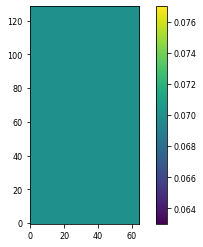

In [12]:
fig,ax = plt.subplots()
cb = ax.imshow(mvel)
fig.colorbar(cb)

In [13]:
# Compute traveltimes for constant model:
t0 = time.time()
%julia D, pEik = getData($m,pEik,false);
tf = time.time()-t0
stf = time.strftime("%H:%M:%S", time.gmtime(tf))
print('\ncomputation time: {0}'.format(stf))


computation time: 00:00:01


In [14]:
# Copy simulated data to python variable:
Dp = %julia D

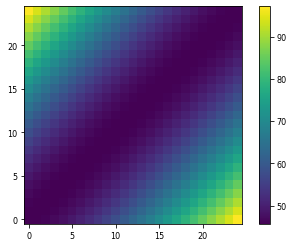

In [15]:
# One should be careful, since julia and python use different ordering (C-style or Fortran-style):
Df = Dp.flatten(order='F')
cb = plt.imshow(Df.reshape(25,25))
plt.colorbar(cb)

[17.8275 21.4251 24.6227 26.2203 27.8178 29.0154 30.613  31.4106 33.4082
 34.2058]
[0.47 0.47 0.47 0.47 0.47 0.47 0.47 0.47 0.47 0.47]
67.1216
17.8275


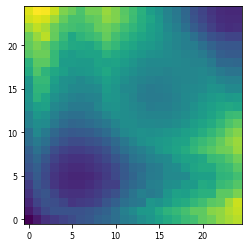

In [16]:
# load traveltime data modelling (generate synthetic data)
loadfile = 'MOG.txt'
dset = np.loadtxt(loadfile,comments='%')
ttdata = 0.4*dset[:,6]-dset[:,-1] # number of sample*sampling rate - ATZ (absolute time zero)
noise = 0.47*np.ones(len(ttdata))

# Check correct loading:
print(ttdata[:10])
print(noise[:10])
print(np.max(ttdata))
print(np.min(ttdata))

ndata = len(ttdata)

fig,ax = plt.subplots()
ax.imshow(ttdata.reshape(25,25))

In [17]:
# for plotting:
x = np.linspace(0.0, bh_spacing, cwid+1)
y = np.linspace(initial_depth, bh_length, chei+1)
dx = (x[1]-x[0])/2.
dy = (y[1]-y[0])/2.
extent = [x[0]-dx, x[-1]+dx, y[-1]+dy, y[0]-dy]

In [18]:
# create source and receiver index array (for getSensTMatVecbatch)
srcind = np.arange(1,26)
recind = np.arange(1,26)
SRC,REC = np.meshgrid(srcind,recind)
SRC = SRC.flatten(order='F')
REC = REC.flatten(order='F')

In [19]:
# Add constrain for valid data
v = np.zeros(nsrc*nrec)
for i in np.arange(len(v)):
    cd = np.abs(SRC[i]-(REC[i]))
    if cd < 8: #14:
        v[i] = 1
    if SRC[i] in [1,2]: # take out measurements for depth < 1.25 m
        v[i] = 0
    if REC[i] in [1,2]: # take out measurements for depth < 1.25 m 
        v[i] = 0

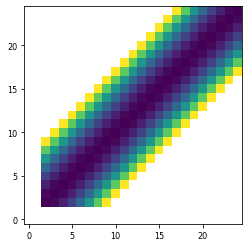

In [20]:
# Create mask for invalid data (high offset):
mskdum = np.reshape(v,(25,25),order='F')
mskdum = np.array(mskdum,dtype=bool)
mskdum = np.invert(mskdum)
ttvmasked = np.ma.array(Dp,mask=mskdum)

# Plot masked data:
fig,ax = plt.subplots()
ax.imshow(ttvmasked)

# Save masked indices for later data batching:
mskdumflat = mskdum.flatten()
indtomsk = np.arange(0,625)
indsmasked = indtomsk[~mskdumflat]

In [21]:
indsmasked.shape # check number of valid data

(289,)

In [22]:
# Get a vector of ones only in masked values (to compute "coverage" or total sensitivity)
onesmasked = ~mskdumflat
onesmasked.shape

(625,)

## Check sensitivity of forward model:

In [23]:
# Compute J'v, where J' is the transposed Jacobian and v is the previously mentioned vector of ones.
%julia onedum = $onesmasked; mdum = reshape($m,length($m)); Jv = getSensTMatVec(onedum,mdum,pEik);

In [24]:
#%julia using jInv.ForwardShare;
#%julia Jj = getSensMat(mdum,pEik);
#J = %julia Jj

In [25]:
#J.shape

In [26]:
# How it is done in julia:
#tve = np.zeros(129*65)
#tve[4] = 1
#coverSens = J@tve
#fig,ax = plt.subplots()
#cb = ax.imshow(coverSens.reshape((25,25),order='F'))
#fig.colorbar(cb)

In [27]:
# Copy J'v to python variable:
Jvp = %julia Jv

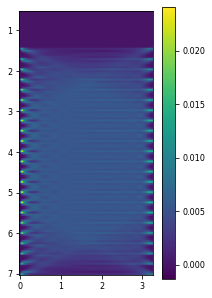

In [28]:
# Plot total sensitivity (only for valid data):
fig,ax = plt.subplots(figsize=(3,5))
cpj = ax.imshow(Jvp.reshape(129,65,order='F'),extent=extent,origin='upper')
fig.colorbar(cpj)

In [29]:
# Get J'v for only one source:
%julia onedum = zeros($nrec*$nsrc); onedum[2]=1.0; mdum = reshape($m,length($m)); Jrow = getSensTMatVec(onedum,mdum,pEik);

In [30]:
Jrowp = %julia Jrow

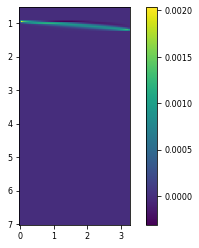

In [31]:
fig, ax = plt.subplots()
cpj = ax.imshow(Jrowp.reshape(chei,cwid,order='F'),extent=extent,origin='upper')
fig.colorbar(cpj)

In [32]:
# Import a module where the function was partially rewritten to allow for data batching:
%julia include("getSensTMatVecbatch.jl");

In [33]:
# Select a few data (by specifying source and receiver number):
SRCtest = SRC[[1,26,54]]
RECtest = REC[[1,3,5]]
%julia onedum = ones($nrec*$nsrc); mdum = reshape($m,length($m)); Jtest = getSensTMatVecbatch(onedum,$SRCtest,$RECtest,pEik);

In [34]:
Jtestp = %julia Jtest

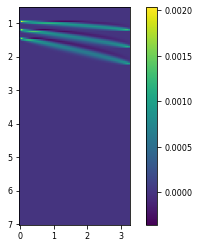

In [35]:
fig, ax = plt.subplots()
cpj = ax.imshow(Jtestp.reshape(chei,cwid,order='F'),extent=extent,origin='upper')
fig.colorbar(cpj)

In [36]:
#jacrow = np.array(tt.fop.jacobian().row(7))
#fig, ax = plt.subplots()
#cpj = ax.imshow(jacrow.reshape(chei,cwid))
#fig.colorbar(cpj)

In [37]:
%julia length(pEik.eikonalParams)

25

## Load trained VAE and perform VAE-SGD inversion:

In [38]:
# check if GPU is available
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# !! Here we do not use GPU for generation since it does not provide noticeable computational gain,
#    however for larger models it could be useful.
device = 'cpu'
cuda = False
# Define the latent space dimension:
z_dim = 40

# Settings for multi-CPU or GPU:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
if str(device) == 'cuda':
    cuda=True
else:
    cuda=False

# String to load the different cases of trained VAE:
casestr = 'tl2ts2'

# Load the VAE already trained:
os.chdir('training')
from autoencoder_ReLU import VAE
gpath = 'VAE100eps40_{0}.pth'.format(casestr)
dnnmodel = VAE(cuda=cuda, gpath=gpath,z_dim=z_dim)
for param in dnnmodel.parameters():
    param.requires_grad = False
dnnmodel.to(device)
dnnmodel.eval() # set evaluation mode (as opposed to training mode).
netG = dnnmodel.decode
os.chdir(workdir)

In [39]:
# Main function for SGD-VAE inversion
# Note: since it relies in both python and julia, it was easier to define it here than to load as a module,
# however there might 'cleaner' ways to do it than the one used here. Sorry for the long cell...
from dataclasses import dataclass
from scipy.stats import chi

@dataclass
class SGDsetup:
    epochs: int = 1
    batch_size: int = 1
    lr: float = 1e-4
    clr: float = 1.0
    ninits: int = 1
    zinit: np.ndarray = np.zeros(1)
    velinit: np.array = np.array([0.05,0.15])
    gen: nn.Module = None
    fwd: str = ''
    A: np.ndarray = np.zeros(1)
    #tt: str = None
    d: np.ndarray = np.zeros(1)
    #clip: str = ''
    reg: str = ''
    #alpha: float = 0.0
    lam: float = 0.0
    clam: float = 1.0
    device: str = ''
    step_eps: int = 1
    DGM: str = 'VAE'
    optimizer: str = 'SGD'
    truemodel: np.ndarray = np.zeros(1)

def SGD_ninits(setup):
    """Perform stochastic gradiend descent for a number of initial models.
    Arguments:
    setup -- SGDsetup object which contains SGD parameters.
    """
    print_SGDsetup(setup)
    dRMSEs = []
    models_costmin = []
    zs_hist = []
    mRMSEs = []
    vel_hist = []
    for j in range(setup.ninits):
        # call SGD_DGM_linear with one initial model:
        zi = setup.zinit[j]
        dloss, mloss, modelmin, vels, zs = SGD_DGM(setup,zi)
        dRMSEs.append(np.sqrt(np.array(dloss)/len(indsmasked)))
        models_costmin.append(modelmin)
        vel_hist.append(vels)
        zs_hist.append(zs)
        mRMSEs.append(mloss)
        minit = np.argmin(dRMSEs[-1])
        print('init: {0}, dRMSE: {1:.4f}, mRMSE: {2:.4f}, ||z||: {3:.4f}'.format(j, 
              dRMSEs[-1][minit], mRMSEs[-1][minit], np.linalg.norm(zs_hist[-1][minit])))

    return dRMSEs,mRMSEs,models_costmin,vel_hist,zs_hist

def SGD_DGM(setup,zi):
    """Perform stochastic gradiend descent for one model and a linear forward operator.
    Arguments:
    setup -- SGDsetup object which contains SGD parameters.
    zi -- initial model as np.ndarray.
    """
    #optimizer = optim.Adam([z], lr=lr)
    nz = setup.zinit.shape[1]
    if setup.DGM == 'VAE':
        z = 1.0*torch.zeros([1, nz]).to(setup.device)
        z.data = torch.Tensor(zi.reshape(1,-1)).to(setup.device) # set initial latent vector
        
    z.requires_grad = True
    #rvel = np.array([0.01,0.18])
    rvel = setup.velinit # set initial values for linear velocity model
    #rvel.requires_grad = True    
    ndata = len(setup.d)
    nvpix = 129*65
    nz = z.numel()
    lam = setup.lam
    lr = setup.lr
    #sg_its = ndata//setup.batch_size
    sg_its = len(indsmasked)//setup.batch_size # use only valid data
    truemodel = setup.truemodel
    dloss = []
    zs = []
    vels = []
    mloss = []
    # set torch optimizer:
    if setup.optimizer == "SGD":
        optimizer = optim.SGD([z], lr=setup.lr)#, momentum=0.5)
    elif setup.optimizer == 'Adam':
        optimizer = optim.Adam([z], lr=setup.lr)
    # send computation vectors to device:
    d = torch.Tensor(setup.d).to(setup.device)
    A = torch.Tensor(setup.A).to(setup.device)
    #tt = setup.tt
    chidist = chi(nz) # Chi-distribution with nz degrees of freedom
    mchi = chidist.mean()
    #print('mchi: {}'.format(mchi))
    zs.append(np.copy(z.data.cpu().numpy())) # save initial z
    vels.append(rvel) # save initial velocity vector
    for it in range(setup.epochs): 
        mask = np.zeros(ndata, dtype=bool) # initiliaze mask for data batching
        mask[indsmasked] = True # set only valid data
        inds_init = np.arange(0,ndata)
        inds_left = np.copy(indsmasked)
        for sg in range(sg_its):
            #fig,ax = plt.subplots(1,2)
            # get data batch indices:
            rand_outs = np.random.choice(len(inds_left),setup.batch_size,replace=False)
            inds_batch = inds_left[rand_outs]
            mask[inds_batch] = False # take out indices of current batch from mask
            #plt.imshow(mask.reshape(25,25))
            inds_left = inds_init[mask] # take out indices of current batch
            #print(inds_left)
            #print('indsleft len: {}'.format(len(inds_left)))

            # Produce model from z
            x0 = setup.gen(z)
            
            x=np.copy(x0.data.cpu().numpy()) # copy x into numpy array.
            #plt.imshow(x.reshape(129,65))
            v_model = rvel[0] + rvel[1]*(x0)
            s_model=1/v_model

            if setup.fwd == 'nonlinear':
                s_m = s_model.detach().cpu().numpy()
                mslowsq = np.array(s_m**2,dtype=np.float64)
                # get traveltimes:
                %julia simj, pEik = getData($mslowsq,pEik,false);
                sim = %julia simj
                sim = sim.flatten(order='F')
                sim = torch.Tensor(sim).to(setup.device)
                lv = -2*(s_m.flatten(order='F')**3)*np.ones([nvpix]) # derivative of squared slowness w.r.t. lower limit of velocity
                ul = -2*(s_m.flatten(order='F')**3)*(x.flatten(order='F'))
                lv = np.array(lv,dtype=np.float64)
                ul = np.array(ul,dtype=np.float64)
                # get Jacobian for linear velocity parameters:
                %julia mdum = reshape($mslowsq,length($mslowsq)); Kvj1 = getSensMatVec($lv,mdum,pEik);
                %julia mdum = reshape($mslowsq,length($mslowsq)); Kvj2 = getSensMatVec($ul,mdum,pEik);
                Kv1 = %julia Kvj1
                Kv2 = %julia Kvj2
                Kv = np.concatenate([Kv1.reshape((-1,1)),Kv2.reshape((-1,1))],axis=1)
                Ksgd = Kv[inds_batch]
                    
            elif setup.fwd == 'linear':
                sim=torch.mv(A,s_model.flatten())
            
            e=d[inds_batch]-sim[inds_batch] # get residuals for batch
            ec=d-sim # get residuals for complete data (including invalid)
            databatch_loss = torch.sum(e**2)
            optimizer.zero_grad()
            
            if setup.fwd == 'linear':
                databatch_loss.backward()
            elif setup.fwd == 'nonlinear':
                ec = ec.detach().cpu().numpy()
                SRCb = SRC[inds_batch]
                RECb = REC[inds_batch]
                # get Jacobian only for data batch:
                %julia gradj = getSensTMatVecbatch($ec,$SRCb,$RECb,pEik);
                grad = %julia gradj
                grad = grad.reshape((129,65),order='F')
                grad = grad.flatten()
                grad = -2*(s_m.flatten()**3)*grad # gradient computed w.r.t. velocity instead of squared slowness
                grad = -torch.Tensor(grad)
                gradvel = np.matmul(-Ksgd.T,e.T.detach().cpu().numpy()) # gradient for velocity parameters
                x0.backward(grad.reshape(x0.shape).to(setup.device)) # compute gradients w.r.t. latent vector

            reg_loss = 0.0
            if setup.reg=='origin':
                reg_loss = lam*torch.norm(z)**2 # regularization (Bora et al., 2017)
                reg_loss.backward()
            if setup.reg=='ring':
                reg_loss = lam*(torch.norm(z)-mchi)**2 # regularization to most common patterns
                reg_loss.backward()

            optimizer.step() # gradient step in latent space
            print(rvel)
            print('vmax = {}, vmin = {}'.format(np.max(1/s_m),np.min(1/s_m)))
            curlr = optimizer.param_groups[0]['lr']
            print('lr = {}, lam = {}'.format(curlr,lam))
            #if it>5:
            rvel = rvel - 1e-4*curlr*gradvel # gradient step for linear velocity parameters
            
            if not ((sg_its*it+sg+1)%setup.step_eps): # update lr and lam every "step_eps" iterations.
                lam = setup.clam*lam
                #lr = setup.clr*lr
                for param_group in optimizer.param_groups:
                    param_group['lr'] = setup.clr*curlr

            data_loss = torch.sum((d[indsmasked]-sim[indsmasked])**2) # SSE for valid data
            total_cost = data_loss + reg_loss
            
            model_loss = np.sqrt(np.mean((truemodel.flatten() - x.flatten())**2)) # w.r.t to zero (constant) model
            
            if sg_its*it+sg==0: cost_min = total_cost.item()

            if total_cost.item()<=cost_min: # check if it is minimum cost
                cost_min = total_cost.item()
                modelmin = np.copy(x[0,0,:,:]) # 'decoded' model is saved only for minimum.

            # to save results:
            dloss.append(data_loss.detach().cpu().numpy())
            zs.append(np.copy(z.data.cpu().numpy()))
            vels.append(rvel)
            mloss.append(model_loss)

            if setup.fwd == 'nonlinear':
                print('it: {0}, RMSE: {1}, znorm: {2}'.format(sg_its*it+sg, 
                      np.sqrt(data_loss.detach().cpu()/len(indsmasked)), np.linalg.norm(zs[-2])))
    
    # Compute RMSE for last iteration:
    x0 = setup.gen(z)
    x=np.copy(x0.data.cpu().numpy()) # copy x into numpy array.
    v_model = rvel[0] + rvel[1]*(x0)
    s_model=1/v_model
    
    if setup.fwd == 'nonlinear':
        s_m = s_model.detach().cpu().numpy()
        mslowsq = np.array(s_m**2,dtype=np.float64)
        %julia simj, pEik = getData($mslowsq,pEik,false);
        sim = %julia simj
        sim = sim.flatten(order='F')
        sim = torch.Tensor(sim).to(setup.device)
        
        
    elif setup.fwd == 'linear':
        sim=torch.mv(A,s_model.flatten())
        
    data_loss = torch.sum((d[indsmasked]-sim[indsmasked])**2)
    model_loss = np.sqrt(np.mean((truemodel.flatten() - x.flatten())**2))
    
    dloss.append(data_loss.detach().cpu().numpy())
    mloss.append(model_loss)
    
    if setup.fwd == 'nonlinear':
        print('it: {0}, RMSE: {1}, znorm: {2}'.format(sg_its*it+sg+1, 
              np.sqrt(data_loss.detach().cpu()/len(indsmasked)), np.linalg.norm(zs[-1])))
            
    return dloss, mloss, modelmin, vels, zs

def print_SGDsetup(setup):
    ndata = len(indsmasked)
    sg_its = ndata//setup.batch_size
    its = setup.epochs*(sg_its)
    v = ("DGM: {0}, epochs: {1}, iterations: {2}, batch_size: {3}, step_eps: {4} \n"
    "lr: {5:.1e},  clr: {6:.3f}, reg: {7}, lam: {8:.1e},  clam: {9:.3f}, optimizer: {10} \n").format(setup.DGM,
         setup.epochs,its,setup.batch_size,setup.step_eps,setup.lr,setup.clr,setup.reg,setup.lam,setup.clam,
         setup.optimizer)
    print(v)

Perform SGD for several initial models:

In [40]:
# set global constants
SGDpars = SGDsetup() # initialize data object containing SGD parameters
SGDpars.d = ttdata # "true" data (with or without added noise)
SGDpars.ninits = 1 # number of initial models to test for convergence (for inversion of a single model set to 1)
SGDpars.fwd = 'nonlinear' # either: 'linear' or 'nonlinear'
SGDpars.device = device # device to use with pytorch

In [41]:
# Different ways to define the initial model(s):

# Directly from a Normal distribution of size z_dim:
#zin = np.random.randn(1,z_dim)

# Sampling from a "ring" in the most common patterns, as defined by the mean of a Chi-distribution:
#chidist = chi(z_dim)
#mchi = chidist.mean()
#stdchi = chidist.std()
#radvec = np.random.rand(1,z_dim)
#radvecunit = radvec/np.linalg.norm(radvec)
#zin = mchi*radvecunit#+stdchi*np.random.randn()

# Loading an array with samples of the correct size
runint = 0
zin = np.load('zinit_d40s100.npy') # dimensions: number of samples x latent space dimension
zin = zin[runint].reshape(1,-1)

In [42]:
# Define inversion parameters and run the VAE-SGD inversion:

SGDpars.epochs = 20 # number of epochs (total number of iterations is n_eps*(ndata/batch_size))
SGDpars.batch_size = 19 #len(indsmasked) # size of data batch (must be an integer factor of ndata)
SGDpars.zinit = zin # load initial models (latents)
SGDpars.velinit = np.array([0.01,0.18]) # initial values for velocity linear model.
SGDpars.DGM = 'VAE'
SGDpars.gen = netG # generator function from DGM
SGDpars.reg = 'origin' # use 'ring', 'origin' or 'none'
SGDpars.lr = 0.005 # initial value for learning rate.
SGDpars.optimizer = 'SGD' # use 'SGD' or 'Adam'
SGDpars.clr = 0.99 # constant for decreasing learning rate.
SGDpars.lam = 100 # initial value for regularization factor (in this case works in the latent space).
SGDpars.clam = 0.85 # constant for decreasing regularization factor lambda.
SGDpars.step_eps = 3 # number of epochs for which to decrease learning rate and reg. factor
#SGDpars.truemodel = x_true
t0 = time.time()
dRMSEs,mRMSEs,models_costmin,vels,zs = SGD_ninits(SGDpars)
tf = time.time()-t0
stf = time.strftime("%H:%M:%S", time.gmtime(tf))
print('\ncomputation time: {0}'.format(stf))

DGM: VAE, epochs: 20, iterations: 300, batch_size: 19, step_eps: 3 
lr: 5.0e-03,  clr: 0.990, reg: origin, lam: 1.0e+02,  clam: 0.850, optimizer: SGD 

[0.01 0.18]
vmax = 0.1423991620540619, vmin = 0.06334114819765091
lr = 0.005, lam = 100
it: 0, RMSE: 8.525675773620605, znorm: 6.285154342651367
[-0.00145661  0.17331222]
vmax = 0.1188480481505394, vmin = 0.041976362466812134
lr = 0.005, lam = 100
it: 1, RMSE: 13.994258880615234, znorm: 7.230295658111572
[0.09064862 0.2074074 ]
vmax = 0.3214012384414673, vmin = 0.1283356249332428
lr = 0.005, lam = 100
it: 2, RMSE: 22.328468322753906, znorm: 30.980798721313477
[0.07741897 0.19830178]
vmax = 0.20619051158428192, vmin = 0.13727796077728271
lr = 0.00495, lam = 85.0
it: 3, RMSE: 14.289210319519043, znorm: 1.07841157913208
[0.05796295 0.19140038]
vmax = 0.18885305523872375, vmin = 0.10092872381210327
lr = 0.00495, lam = 85.0
it: 4, RMSE: 10.642850875854492, znorm: 8.523859024047852
[0.03704475 0.18411329]
vmax = 0.12250057607889175, vmin = 0.

[0.02657822 0.15098309]
vmax = 0.13555631041526794, vmin = 0.06263197213411331
lr = 0.004300291773206443, lam = 8.735421910125167
it: 45, RMSE: 2.7471418380737305, znorm: 7.7790751457214355
[0.02868197 0.15190943]
vmax = 0.13795530796051025, vmin = 0.06632614880800247
lr = 0.004300291773206443, lam = 8.735421910125167
it: 46, RMSE: 2.160478115081787, znorm: 7.362504005432129
[0.03057264 0.15250127]
vmax = 0.14006276428699493, vmin = 0.06852325797080994
lr = 0.004300291773206443, lam = 8.735421910125167
it: 47, RMSE: 1.8395591974258423, znorm: 6.983691692352295
[0.02906793 0.15177588]
vmax = 0.13685786724090576, vmin = 0.0676330178976059
lr = 0.0042572888554743785, lam = 7.425108623606391
it: 48, RMSE: 2.319673538208008, znorm: 6.237532615661621
[0.03424019 0.15361331]
vmax = 0.14544013142585754, vmin = 0.07386019080877304
lr = 0.0042572888554743785, lam = 7.425108623606391
it: 49, RMSE: 2.0808632373809814, znorm: 6.304955005645752
[0.02973586 0.15175469]
vmax = 0.13419055938720703, vmi

[0.0321701  0.15211236]
vmax = 0.14386817812919617, vmin = 0.0730060338973999
lr = 0.0037358604716579815, lam = 0.8977364229164096
it: 89, RMSE: 0.8082514405250549, znorm: 4.7055745124816895
[0.03328076 0.15253348]
vmax = 0.14521637558937073, vmin = 0.07377717643976212
lr = 0.003698501866941402, lam = 0.7630759594789481
it: 90, RMSE: 0.8905067443847656, znorm: 4.773283958435059
[0.03156401 0.15194603]
vmax = 0.14256998896598816, vmin = 0.07191632688045502
lr = 0.003698501866941402, lam = 0.7630759594789481
it: 91, RMSE: 1.013460397720337, znorm: 4.653954029083252
[0.03346808 0.15280074]
vmax = 0.14471988379955292, vmin = 0.07417318224906921
lr = 0.003698501866941402, lam = 0.7630759594789481
it: 92, RMSE: 1.193906307220459, znorm: 5.024252414703369
[0.03040823 0.15154242]
vmax = 0.14062082767486572, vmin = 0.0715990737080574
lr = 0.003661516848271988, lam = 0.6486145655571058
it: 93, RMSE: 1.5231579542160034, znorm: 4.744624137878418
[0.03393288 0.15285902]
vmax = 0.14580664038658142, 

[0.03247363 0.15204493]
vmax = 0.14558035135269165, vmin = 0.0748782753944397
lr = 0.003213058010423591, lam = 0.07842106418261396
it: 132, RMSE: 0.7148244976997375, znorm: 5.359795093536377
[0.031474   0.15162092]
vmax = 0.143162339925766, vmin = 0.07242851704359055
lr = 0.003213058010423591, lam = 0.07842106418261396
it: 133, RMSE: 1.072062611579895, znorm: 5.234078407287598
[0.0333223  0.15244632]
vmax = 0.1469065248966217, vmin = 0.07498341798782349
lr = 0.003213058010423591, lam = 0.07842106418261396
it: 134, RMSE: 0.9679006338119507, znorm: 5.500135898590088
[0.03113108 0.15156891]
vmax = 0.14298062026500702, vmin = 0.07293200492858887
lr = 0.0031809274303193553, lam = 0.06665790455522187
it: 135, RMSE: 1.057969331741333, znorm: 5.285707950592041
[0.03303981 0.15232385]
vmax = 0.14714133739471436, vmin = 0.07421253621578217
lr = 0.0031809274303193553, lam = 0.06665790455522187
it: 136, RMSE: 0.8815550208091736, znorm: 5.4527692794799805
[0.03166173 0.15174749]
vmax = 0.1438311040

[0.03177994 0.15185657]
vmax = 0.14306268095970154, vmin = 0.07329466938972473
lr = 0.002791330692739318, lam = 0.008059306850307505
it: 175, RMSE: 0.7436752915382385, znorm: 5.389860153198242
[0.03230053 0.1520771 ]
vmax = 0.1441693753004074, vmin = 0.07419417053461075
lr = 0.002791330692739318, lam = 0.008059306850307505
it: 176, RMSE: 0.6707021594047546, znorm: 5.45623779296875
[0.03227204 0.1520374 ]
vmax = 0.1436879187822342, vmin = 0.07442311942577362
lr = 0.0027634173858119247, lam = 0.006850410822761379
it: 177, RMSE: 0.6669765114784241, znorm: 5.41221809387207
[0.03169237 0.15184186]
vmax = 0.14300769567489624, vmin = 0.0739942193031311
lr = 0.0027634173858119247, lam = 0.006850410822761379
it: 178, RMSE: 0.7940043807029724, znorm: 5.35615873336792
[0.03313425 0.15236563]
vmax = 0.14527630805969238, vmin = 0.07609444856643677
lr = 0.0027634173858119247, lam = 0.006850410822761379
it: 179, RMSE: 0.8700819611549377, znorm: 5.450562953948975
[0.03164256 0.15181535]
vmax = 0.14286

[0.0320323  0.15225098]
vmax = 0.14295777678489685, vmin = 0.07437306642532349
lr = 0.002424956851370814, lam = 0.0008282523016540943
it: 218, RMSE: 0.6615012884140015, znorm: 5.5012712478637695
[0.03171658 0.15218518]
vmax = 0.1431216448545456, vmin = 0.07371339946985245
lr = 0.002400707282857106, lam = 0.0007040144564059802
it: 219, RMSE: 0.6798987984657288, znorm: 5.519324779510498
[0.03171138 0.15218675]
vmax = 0.1430702805519104, vmin = 0.07349825650453568
lr = 0.002400707282857106, lam = 0.0007040144564059802
it: 220, RMSE: 0.6764349937438965, znorm: 5.51628303527832
[0.03212787 0.15234548]
vmax = 0.1434742957353592, vmin = 0.07424595952033997
lr = 0.002400707282857106, lam = 0.0007040144564059802
it: 221, RMSE: 0.6567885875701904, znorm: 5.54408073425293
[0.03202763 0.15228485]
vmax = 0.14338567852973938, vmin = 0.07415309548377991
lr = 0.0023767002100285347, lam = 0.0005984122879450831
it: 222, RMSE: 0.661555826663971, znorm: 5.497726917266846
[0.03254638 0.15255101]
vmax = 0.1

[0.03162965 0.15224181]
vmax = 0.14224791526794434, vmin = 0.07421968877315521
lr = 0.0020856043996661023, lam = 7.235133302980775e-05
it: 261, RMSE: 0.6660035252571106, znorm: 5.5010504722595215
[0.03193267 0.15237159]
vmax = 0.14275331795215607, vmin = 0.07455814629793167
lr = 0.0020856043996661023, lam = 7.235133302980775e-05
it: 262, RMSE: 0.6533189415931702, znorm: 5.530825614929199
[0.03177835 0.15230214]
vmax = 0.14247359335422516, vmin = 0.07435144484043121
lr = 0.0020856043996661023, lam = 7.235133302980775e-05
it: 263, RMSE: 0.6558569669723511, znorm: 5.485764026641846
[0.03214864 0.15243913]
vmax = 0.14308874309062958, vmin = 0.07471192628145218
lr = 0.0020647483556694413, lam = 6.149863307533659e-05
it: 264, RMSE: 0.6552236080169678, znorm: 5.509624004364014
[0.03192528 0.1523531 ]
vmax = 0.14275522530078888, vmin = 0.0745738074183464
lr = 0.0020647483556694413, lam = 6.149863307533659e-05
it: 265, RMSE: 0.6533127427101135, znorm: 5.491408824920654
[0.03174446 0.15229076]
v

accepted model ring clip: 0
lr = 0.005
min for iteration #: 281
min data RMSE: 0.6341336965560913
z norm at min: 5.527499675750732
z at min:[[ 0.45   1.254 -0.745 -0.847 -1.824 -0.49  -0.735  0.035  0.959 -0.07
  -0.878 -0.844  0.015 -0.022 -0.811  0.511 -1.131  2.577 -0.272  0.381
   0.242 -0.004  1.457  0.588  0.118 -1.609  0.125  0.184  0.771  0.964
  -0.474 -0.015  0.745  0.22  -1.634 -0.066  0.263 -0.421  1.208 -0.136]]


<ipython-input-43-c961bda227c9>:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


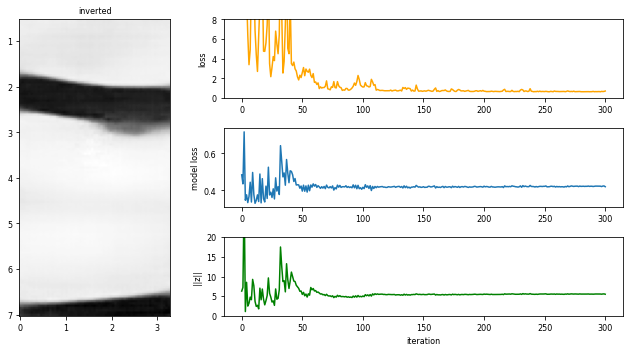

In [43]:
# Extract values in minimum for each initial model:
suffix = 'mc1'
dRMSEs_min = []
zs_min = []
for i in range(len(dRMSEs)):
    it_min = np.argmin(dRMSEs[i])
    dRMSEs_min.append(dRMSEs[i][it_min])
    zs_min.append(zs[i][it_min])

# Number of accepted models:
updict = {'mc1':0.620,'mc2':0.757,'mc3':1.440,'mv1':1.119,'mv2':1.046,'mv3':1.363}
uplim = updict[suffix]
acmods = np.sum(np.array(dRMSEs_min)<=uplim)
print('accepted model ring clip: {0}'.format(acmods))

# Plot dRMSE vs iterations for one model.
mi = 0
datcost = dRMSEs[mi]
modelcost = mRMSEs[mi]
it_min = np.argmin(datcost)
print('lr = {0}'.format(SGDpars.lr))
print('min for iteration #: {0}'.format(it_min))
print('min data RMSE: {0}'.format(dRMSEs_min[mi]))
print('z norm at min: {0}'.format(np.linalg.norm(zs_min[mi])))
with np.printoptions(precision=3, suppress=True):
    print('z at min:{0}'.format(zs_min[mi]))

# Get znorms vs. iterations
znorms = np.zeros(len(zs[0]))
for i in range(len(znorms)):
    znorms[i] = np.linalg.norm(zs[mi][i][:][0])

# joint subplot
fig = plt.figure(figsize=(9,5), constrained_layout=True)
grid = fig.add_gridspec(3,3)

# first
ax = fig.add_subplot(grid[:,0])
ax.imshow(models_costmin[mi], cmap='Greys', extent=extent, origin='upper')
ax.set_title('inverted')

# second
#ax = fig.add_subplot(grid[:,1])
#ax.imshow(x_true[0,0,:,:], cmap='Greys_r')
#ax.set_title('true')

# third
ax = fig.add_subplot(grid[0,1:])
ax.plot(datcost, c='orange')
ax.set_ylim((0.0,8.0))
ax.set_ylabel('loss')

# fourth
ax = fig.add_subplot(grid[1,1:])
ax.plot(modelcost)
#ax.set_ylim((0.0,1.0))
ax.set_ylabel('model loss')

# fifth
ax = fig.add_subplot(grid[2,1:])
ax.plot(znorms,c='g')
ax.set_ylim((0.0,20.0))
ax.set_ylabel('||z||')
ax.set_xlabel('iteration')

fig.tight_layout()

## Check and save results:

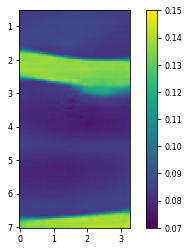

In [44]:
# plot one inverted velocity model:
fig,ax = plt.subplots() 
model_p = vels[0][it_min][0]+vels[0][it_min][1]*(models_costmin[mi])
vmax,vmin = 0.15,0.07
cb = ax.imshow(model_p,vmin=vmin,vmax=vmax, extent=extent, origin='upper')
fig.colorbar(cb)

In [45]:
print(np.max(models_costmin[mi]))
print(np.min(models_costmin[mi]))

0.7293442
0.28122896


(array([ 536., 1824., 2631., 1518.,   68.,   48.,   36.,   33.,   34.,
          27.,   51.,   52.,   57.,   48.,   35.,   56.,  140.,  420.,
         653.,  118.]),
 array([0.07469866, 0.07811352, 0.08152838, 0.08494324, 0.0883581 ,
        0.09177297, 0.09518783, 0.09860269, 0.10201755, 0.10543241,
        0.10884728, 0.11226214, 0.115677  , 0.11909186, 0.12250672,
        0.12592158, 0.12933645, 0.13275132, 0.13616617, 0.13958102,
        0.1429959 ], dtype=float32),
 <BarContainer object of 20 artists>)

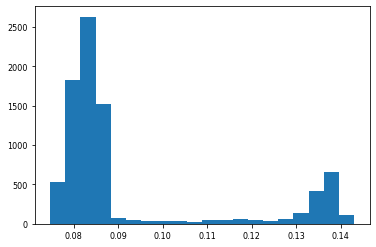

In [46]:
# histogram of velocities for inverted model:
plt.hist(model_p.flatten(),bins=20)

In [47]:
# Save results:
# create directory first time or only use as target for save when it already exists:
runstr = '{0}'.format(runint)
sdir = 'Results_{}'.format(casestr)
if sdir not in os.listdir():
    os.mkdir(sdir)

In [48]:
# save all

# save as numpy arrays
np.save('./{0}/dRMSEs_{1}.npy'.format(sdir,runstr),np.array(dRMSEs))
np.save('./{0}/mRMSEs_{1}.npy'.format(sdir,runstr),np.array(mRMSEs))
np.save('./{0}/modsmin_{1}.npy'.format(sdir,runstr),np.array(models_costmin))
np.save('./{0}/vels_{1}.npy'.format(sdir,runstr),np.array(vels))
np.save('./{0}/zs_{1}.npy'.format(sdir,runstr),np.array(zs))
#np.save('./{0}/zinit_{1}.npy'.format(sdir,runstr),SGDpars.zinit)

print('saved for case: {0}, run: {1}'.format(casestr,runstr))

saved for case: tl2ts2, run: 0


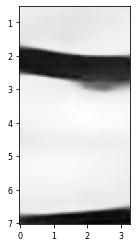

In [49]:
# Check decoding of inverted latent vector z:
modit = dnnmodel.decode(torch.tensor(zs[0][it_min]).to(device))

fig,ax = plt.subplots()

ax.imshow(modit.detach().cpu().numpy()[0,0,:,:],cmap='Greys',extent=extent, origin='upper')

0.6341337
281
(1, 301)


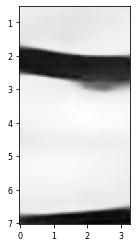

In [50]:
# load saved model:
#sdir = 'Results_{0}'.format(casestr)
#runstr = '0'
modload = np.load('./{0}/modsmin_{1}.npy'.format(sdir,runstr))
dRMSEload = np.load('./{0}/dRMSEs_{1}.npy'.format(sdir,runstr))
velsload = np.load('./{0}/vels_{1}.npy'.format(sdir,runstr))
zsload = np.load('./{0}/zs_{1}.npy'.format(sdir,runstr))
#zinitload = np.load('./{0}/zinit_{1}.npy'.format(sdir,runstr))
print(np.min(dRMSEload))
print(np.argmin(dRMSEload))
#print(zinitload)
print(dRMSEload.shape)

fig,ax = plt.subplots()

ax.imshow(modload[0,:,:],cmap='Greys',extent=extent, origin='upper')

## Run forward simulation for inverted model:

In [51]:
modrec = netG(torch.Tensor(zsload[0,it_min:,:]).to(device))
modrec = modrec.detach().cpu().numpy()
modrec = modrec[0,:,:]

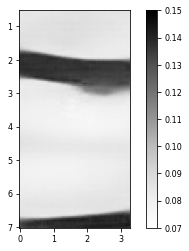

In [52]:
# Build inverted velocity distribution:
it_load = np.argmin(np.array(dRMSEload[0]))
velsinv = velsload[0][it_load]
velocitymodel = velsinv[0] + velsinv[1]*modrec[0]
sqsmodel = 1.0/(velocitymodel)**2
sqsmodel = np.array(sqsmodel,dtype=np.float64)
fig,ax = plt.subplots()
vmax,vmin = 0.15,0.07
cb = ax.imshow(velocitymodel,vmax=vmax,vmin=vmin,cmap='Greys',extent=extent, origin='upper')
fig.colorbar(cb)

In [53]:
print(np.min(velocitymodel))
print(np.max(velocitymodel))
print(it_load)

0.074698664
0.1429959
281


In [54]:
velsinv

array([0.03183655, 0.15241   ])

In [55]:
%julia D, pEik = getData($sqsmodel,pEik,false);

In [56]:
Dp = %julia D

In [57]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

0.6341336643037948


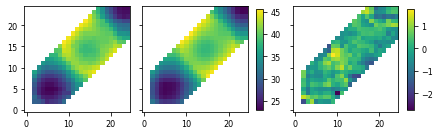

In [58]:
# Mask data and compute RMSE:
mskreal = np.reshape(v,(25,25))
mskreal = np.array(mskreal,dtype=bool)
mskreal = np.invert(mskreal)
realdata = ttdata.reshape((25,25))
realdmasked = np.ma.array(realdata,mask=mskreal)
simdata = Dp.flatten(order='F')
simdata = simdata.reshape((25,25))
simdmasked = np.ma.array(simdata,mask=mskreal)

# Compute overall max and min for traveltime colorbar:
vmax = np.max([np.ma.max(realdmasked),np.ma.max(simdmasked)])
vmin = np.min([np.ma.min(realdmasked),np.ma.min(simdmasked)])

# Plot observed data, simulated data for inverted model and difference (errors).
fig,ax = plt.subplots(1,3,constrained_layout=True)

# Observed data:
cb1 = ax[0].imshow(realdmasked,vmin=vmin,vmax=vmax)

# Simulated data for inverted model:
ax[1].imshow(simdmasked,vmin=vmin,vmax=vmax)
ax[1].set_yticklabels([])
fig.colorbar(cb1,ax=ax[1],shrink=0.35)

# Difference between them (errors):
cb2 = ax[2].imshow(realdmasked-simdmasked)
ax[2].set_yticklabels([])
fig.colorbar(cb2,ax=ax[2],shrink=0.35)

# Compute and print RMSE:
rmse = np.sqrt(np.mean((realdmasked-simdmasked)**2))
print(rmse)

In [59]:
%julia onedum = $onesmasked; mdum = reshape($sqsmodel,length($m)); Jvr = getSensTMatVec(onedum,mdum,pEik);

In [60]:
Jvrp = %julia Jvr

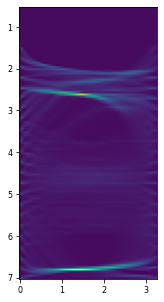

In [61]:
# total sensitivity
fig,ax = plt.subplots(figsize=(3,5))
plt.imshow(Jvrp.reshape(129,65,order='F'),extent=extent,origin='upper')